In [121]:
import requests

import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import time
import datetime

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
import numpy as np
import pandas as pd
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from scipy.stats import bernoulli

import numpy as np
from scipy import stats

# Introduction

Our project will address two research questions: 

1) What is the causal impact of Ozone level on the age-adjusted prevalence of asthma? 

2) Given the selected features, build a model that can predict the age-adjusted prevalence of Asthma.

We will mainly be using three datasets: 

1) Annual State-Level U.S. Chronic Disease Indicators filtered for asthma 

2) Modified PM2.5 dataset 

3) Modified ozone dataset 

(We computed the daily mean PM2.5 and ozone level for each state due to the large size of the two datasets)

In [122]:
asthma = pd.read_csv('Asthma.csv')
asthma.head(5)

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning:

Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.



,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
0,2012,2012,AL,Alabama,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,...,1,AST,AST4_1,NMBR,GENDER,GENF,NaN,NaN,NaN,NaN
1,2014,2014,AL,Alabama,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,...,1,AST,AST4_1,NMBR,GENDER,GENM,NaN,NaN,NaN,NaN
2,2011,2011,AZ,Arizona,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,...,4,AST,AST4_1,NMBR,GENDER,GENM,NaN,NaN,NaN,NaN
3,2015,2015,CT,Connecticut,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,...,9,AST,AST4_1,NMBR,GENDER,GENF,NaN,NaN,NaN,NaN
4,2011,2011,FL,Florida,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,...,12,AST,AST4_1,NMBR,GENDER,GENM,NaN,NaN,NaN,NaN


In [123]:
pm25 = pd.read_csv('PM25.csv').drop('Unnamed: 0', axis = 1)
pm25.head(5)

,statefip,01JAN2011,02JAN2011,03JAN2011,04JAN2011,05JAN2011,06JAN2011,07JAN2011,08JAN2011,09JAN2011,...,22DEC2014,23DEC2014,24DEC2014,25DEC2014,26DEC2014,27DEC2014,28DEC2014,29DEC2014,30DEC2014,31DEC2014
0,1,5.196290,4.984104,7.209600,14.935756,13.690596,8.585039,5.775294,5.281323,5.653868,...,6.277790,4.574800,4.386800,6.835787,10.125804,8.777215,5.365212,6.648250,8.164014,10.379025
1,4,8.827295,7.360635,12.533566,11.775343,10.416504,10.179782,13.626992,9.685872,11.871241,...,15.854941,9.668950,9.149272,8.300927,7.769705,12.176465,11.554488,14.450957,10.587868,9.241211
2,5,5.786716,7.738383,8.606869,11.491568,12.038085,8.903985,5.570338,4.409569,5.063505,...,9.685457,5.797382,5.141571,4.235675,7.013927,5.985645,6.463000,8.268514,10.546440,9.648933
3,6,13.559603,8.105638,7.545573,9.488456,10.519056,12.612504,19.867717,16.772288,14.125612,...,11.942154,7.795916,8.594198,5.446916,5.797357,11.192144,14.167456,14.964028,10.647488,11.708086
4,8,3.949587,5.036296,8.523260,14.477241,4.653650,7.191430,7.362693,14.661273,7.734357,...,3.371333,4.931956,6.957509,3.884519,5.561388,8.712206,13.681786,10.666739,7.372589,13.418500


In [124]:
ozone = pd.read_csv('ozone.csv').drop('Unnamed: 0', axis = 1)
ozone.head(5)

,statefip,01JAN2011,02JAN2011,03JAN2011,04JAN2011,05JAN2011,06JAN2011,07JAN2011,08JAN2011,09JAN2011,...,22DEC2014,23DEC2014,24DEC2014,25DEC2014,26DEC2014,27DEC2014,28DEC2014,29DEC2014,30DEC2014,31DEC2014
0,1,32.721949,34.568758,30.375864,34.251780,25.669446,35.428277,42.567707,37.360915,29.332703,...,18.379176,26.374789,27.970030,24.502318,29.265682,26.539294,21.010491,13.935375,20.869850,20.861829
1,4,37.600710,36.208419,28.965546,22.845798,24.252316,21.691751,27.932608,32.126367,38.859366,...,30.941900,41.052629,35.428706,35.638700,33.114273,29.577865,30.148626,30.046606,31.062371,30.077946
2,5,30.239673,34.037387,34.557988,31.986139,33.764155,39.655212,35.805370,34.693654,27.113124,...,18.632721,26.653000,16.930287,33.680957,24.719975,19.922840,15.101408,20.903627,25.459039,23.421275
3,6,32.563569,28.175180,23.692732,24.940009,20.267972,19.010336,16.436324,22.489915,28.328533,...,19.186271,19.241213,30.206364,36.871303,32.910782,30.952254,29.631145,29.022493,33.305325,32.842572
4,8,37.797404,36.801446,36.713041,41.866961,42.656211,38.958352,33.559118,23.684557,37.000746,...,35.381818,39.690000,28.191967,33.211362,29.620425,31.601164,28.668236,28.348465,26.475895,29.747821


# Data Cleaning

For data cleaning, we first loaded individual datasets and dropped those containing N/A values. We selected columns relevant to our reasearch question, and merged all 3 datasets into one on Year and StateID.\
Since we dropped various rows containing N/A values, the data used to generate models as well as make predictions may not be as accurate. 

### 1) Asthma Dataset

In [125]:
asthma['Question'].value_counts()

Asthma mortality rate                                                                      9816
Current asthma prevalence among adults aged >= 18 years                                    7830
Influenza vaccination among noninstitutionalized adults aged 18-64 years with asthma       7830
Influenza vaccination among noninstitutionalized adults aged >= 65 years with asthma       7830
Pneumococcal vaccination among noninstitutionalized adults aged 18-64 years with asthma    7830
Pneumococcal vaccination among noninstitutionalized adults aged >= 65 years with asthma    7830
Hospitalizations for asthma                                                                6516
Emergency department visit rate for asthma                                                 6312
Asthma prevalence among women aged 18-44 years                                             2925
Name: Question, dtype: int64

Among the 9 questions addressed in the asthma dataset, we will only explore **age-adjusted** 'current asthma prevalence among adults aged >= 18 years' for our project. And we will only use data that are between 2011-2014 to match the time frame in PM2.5 and ozone datasets.

#### Current asthma prevalence among adults aged >= 18 years (age-adjusted rate)

In [126]:
prevalence = asthma[asthma['Question'] == 'Current asthma prevalence among adults aged >= 18 years']
# Select data from 2011-2014
prevalence = prevalence[(prevalence['YearStart'] >= 2011) & (prevalence['YearEnd'] <= 2014) & (prevalence['DataValueTypeID'] == 'AGEADJPREV')]
selected_columns = ['YearStart', 'LocationDesc', 'LocationID', 'DataValue', 'StratificationCategoryID1', 'StratificationID1']
prevalence_selected = prevalence[selected_columns]
prevalence_selected = prevalence_selected. rename(columns={'YearStart':'Year','LocationDesc':'State', 'LocationID': 'StateID',
                                                'DataValue':'Prevalence', 'StratificationCategoryID1':'StratificationCategory',
                                                'StratificationID1':'Stratification'})
# Drop NA rows
prevalence_cleaned = prevalence_selected.dropna()
prevalence_cleaned.head(5)

,Year,State,StateID,Prevalence,StratificationCategory,Stratification
22699,2013,Utah,49,7.2,GENDER,GENM
22721,2014,Alabama,1,9.5,RACE,WHT
22728,2014,Colorado,8,9.1,RACE,OTH
22729,2011,Colorado,8,15.5,RACE,MRC
22730,2011,Arkansas,5,25.5,RACE,MRC


### 2) PM2.5 & Ozone

In [127]:
pm25_cleaned = pm25.melt(id_vars='statefip')
pm25_cleaned = pm25_cleaned.rename(columns={'statefip':'StateID','variable':'Date', 'value': 'PM2.5'})
# Add a year column
pm25_cleaned['Year'] = pm25_cleaned['Date'].str[-4:]
# Group PM2.5 by year and take the mean
pm25_grouped = pm25_cleaned.groupby(["Year", "StateID"]).mean().reset_index()
pm25_grouped.head(5)

,Year,StateID,PM2.5
0,2011,1,10.722394
1,2011,4,7.957158
2,2011,5,10.607418
3,2011,6,10.424960
4,2011,8,6.438329


In [128]:
ozone_cleaned = ozone.melt(id_vars='statefip')
ozone_cleaned = ozone_cleaned.rename(columns={'statefip':'StateID','variable':'Date', 'value': 'Ozone'})
# Add a year column
ozone_cleaned['Year'] = ozone_cleaned['Date'].str[-4:]
# Group ozone level by year and take the mean
ozone_grouped = ozone_cleaned.groupby(["Year", "StateID"]).mean().reset_index()
ozone_grouped.head(5)

,Year,StateID,Ozone
0,2011,1,41.170865
1,2011,4,46.998399
2,2011,5,41.012629
3,2011,6,39.981360
4,2011,8,47.043940


In [129]:
# Merge pm25_grouped with ozone_grouped
pm25_ozone = pd.merge(pm25_grouped, ozone_grouped, how='left', on=['Year','StateID'])
pm25_ozone.head(5)

,Year,StateID,PM2.5,Ozone
0,2011,1,10.722394,41.170865
1,2011,4,7.957158,46.998399
2,2011,5,10.607418,41.012629
3,2011,6,10.424960,39.981360
4,2011,8,6.438329,47.043940


### 3) Merge asthma, PM2.5 and ozone datasets together

In [130]:
# Convert 'Year' column in pm25_ozone to float
pm25_ozone['Year'] = pm25_ozone['Year'].apply(lambda x: float(x))

In [131]:
prevalence_airquality = pd.merge(prevalence_cleaned, pm25_ozone, how='left', on=['Year','StateID'])
# Drop NA rows
prevalence_final = prevalence_airquality.dropna()
prevalence_final.head(5)

,Year,State,StateID,Prevalence,StratificationCategory,Stratification,PM2.5,Ozone
0,2013,Utah,49,7.2,GENDER,GENM,9.311432,41.073701
1,2014,Alabama,1,9.5,RACE,WHT,11.025839,37.455517
2,2014,Colorado,8,9.1,RACE,OTH,6.737662,44.177632
3,2011,Colorado,8,15.5,RACE,MRC,6.438329,47.043940
4,2011,Arkansas,5,25.5,RACE,MRC,10.607418,41.012629


# EDA

1) Asthma: Gender

Text(0.5, 1.0, 'Prevalence VS Gender')

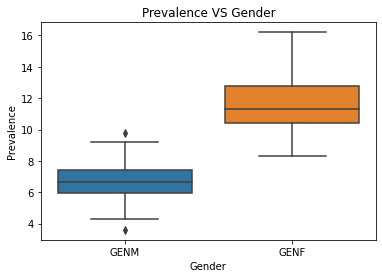

In [132]:
prevalence_gender = prevalence_final[prevalence_final['StratificationCategory'] == 'GENDER']
sns.boxplot(x = 'Stratification', y = 'Prevalence', data = prevalence_gender)
plt.xlabel('Gender')
plt.title('Prevalence VS Gender')

From boxplots generated between mortality and prevalence vs gender, We observed female having both higher mortality rate and prevalence for asthma. We suspect a correlation between gender and asthma prevalence where female are more susceptible to the disease.

Text(0.5, 1.0, 'Age-adjusted prevalence for each year')

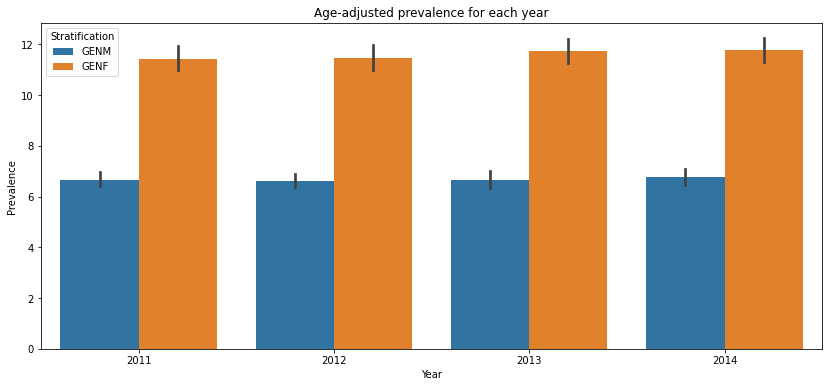

In [133]:
plt.figure(figsize = (14, 6))
prevalence_gender = prevalence_final[prevalence_final['StratificationCategory'] == 'GENDER']
sns.barplot(x = 'Year', y = 'Prevalence', hue = 'Stratification', data = prevalence_gender)
plt.title('Age-adjusted prevalence for each year')

2) Asthma: Race

Text(0.5, 1.0, 'Prevalence VS Race')

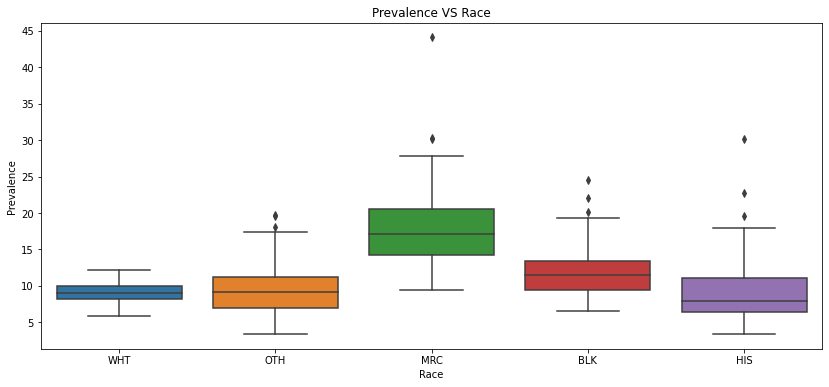

In [134]:
plt.figure(figsize = (14, 6))
prevalence_race = prevalence_final[prevalence_final['StratificationCategory'] == 'RACE']
sns.boxplot(x = 'Stratification', y = 'Prevalence', data = prevalence_race)
plt.xlabel('Race')
plt.title('Prevalence VS Race')

When examining the boxplot between prevalance and race, we see multiracial (MRC) having the highest upperbound and outlier.\
One thing to note is that gender and race has no data reflecting their potential relationship hence when modeling, we either separate them or choose one.

3) Asthma: location/state

<AxesSubplot:xlabel='StateID', ylabel='Prevalence'>

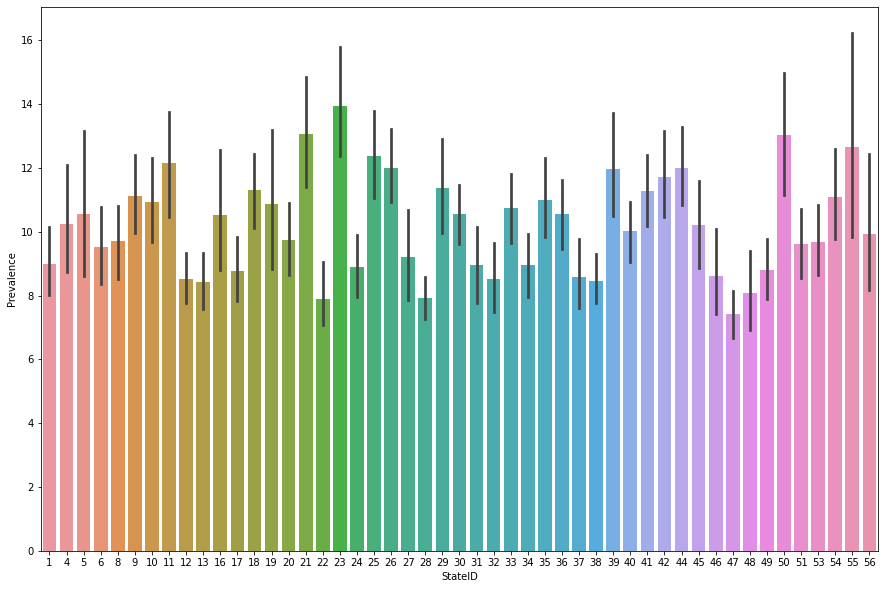

In [135]:
### Add into abbreviations
plt.figure(figsize = (15, 10))

sns.barplot(x = 'StateID', y = 'Prevalence', data = prevalence_final)

We see varying mortality/prevalence of asthma across states, thus we want to include state as a confounding variable when predicting future pm2.5/ozone level on asthma prevalence/mortality.

In [136]:
new = prevalence_race.groupby(['State','Stratification']).size().to_frame().reset_index().pivot(index='State', columns='Stratification', values=0).fillna(0)

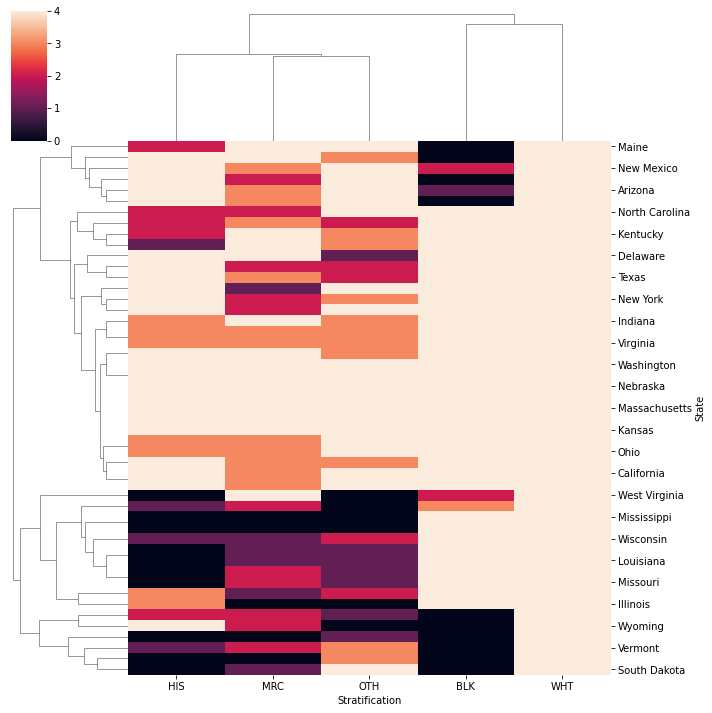

In [137]:
sns.clustermap(new)

From the clustered heatmap above, we see unequal distribution of race along different states. Thus, we are interested in examining the relationship between race and geography, which may both serve as a confounding variable to asthma prevalence/mortality.

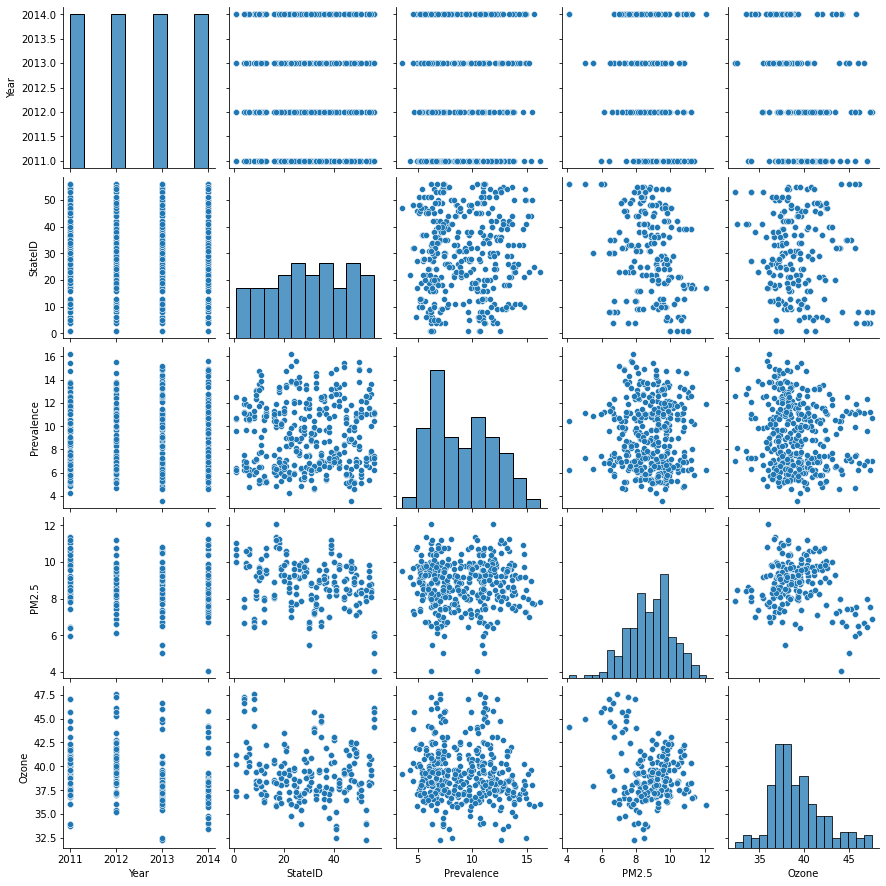

In [138]:
sns.pairplot(prevalence_gender);

- When examining the scatter plot between Ozone and pm2.5 level, we see a negative relationship. Hence PM2.5 is a possible confounder for evaluating the casual effect between Ozone and asthma prevalence.
- When examining the scatter plot above, we don't see clear pattern between Ozone level versus asthma prevalence. However, there may exist various confounding variables that influence the overall trend, for example location(state), year, as well as gender and race.
- The scatter plot between asthma prevalence and year further corroborate our assumption that year has no effect on the prevalence of asthma.

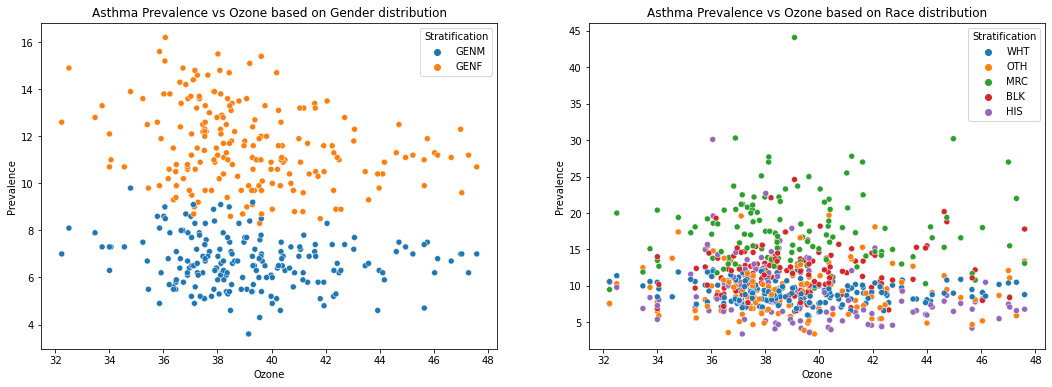

In [139]:
plt.figure(figsize = (18, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=prevalence_gender, x = 'Ozone', y = 'Prevalence', hue='Stratification');
plt.title('Asthma Prevalence vs Ozone based on Gender distribution');

plt.subplot(1, 2, 2)
sns.scatterplot(data=prevalence_race, x = 'Ozone', y = 'Prevalence', hue='Stratification');
plt.title('Asthma Prevalence vs Ozone based on Race distribution');

To further investigate the confounding variables for Ozone's effect on asthma prevalence, we drew scatter plots separated by gender/race. 
- When stratified by gender, we don't observe its effect on the casual relationship between ozone and asthma prevalence as the slopes are very similar. 
- When stratified by race, we see some effect on the casual relationship between ozone and asthma prevalence, for example, BLK has corresponding ozone levels concentrated between 36 to 44 when compared to other races.

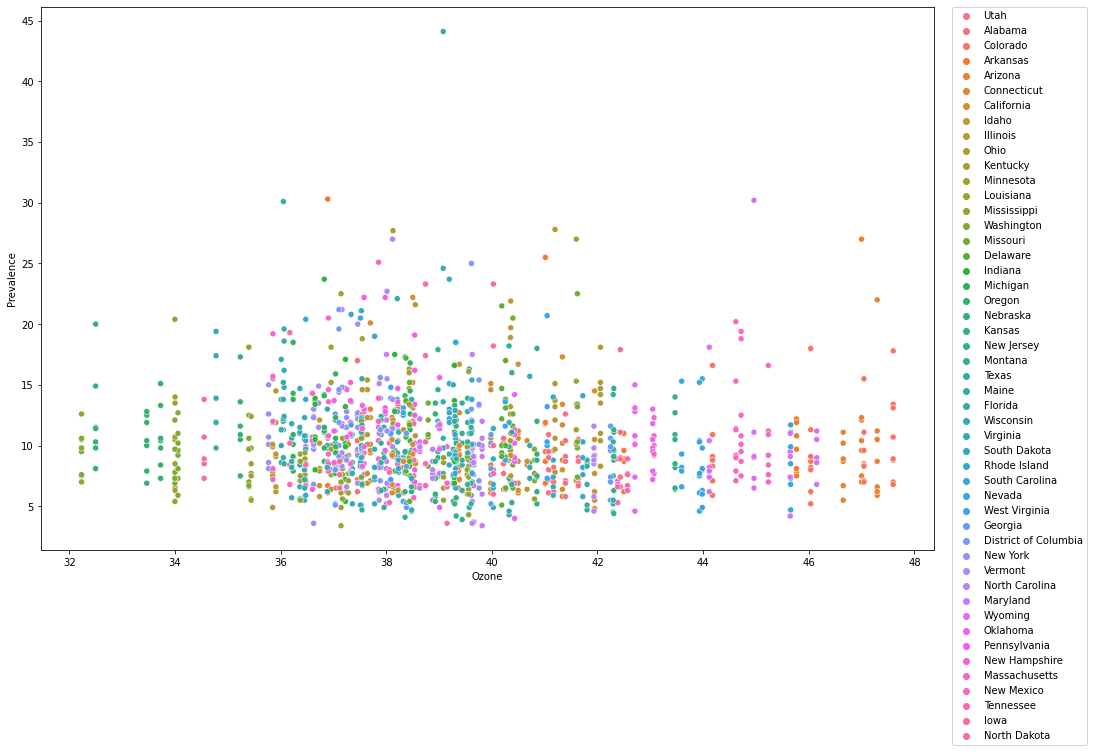

In [140]:
plt.figure(figsize=(16, 10))
sns.scatterplot(data=prevalence_final, x = 'Ozone', y = 'Prevalence', hue='State');
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

To further examine location's effect on Ozone's casual relationship with asthma prevalence, we drew a scatter plot separated by location. We can see a high correlation between state and ozone levels, for example, states shown in green colors are concentrated at the bottom-left of the graph where they have relatively low ozone levels.

Thus, our investigation of the 2 research questions are as follows.

# Research Question 1: What's the causal impact of ozone level on age-adjusted asthma prevalence?

(Due to the limitation of the asthma data set, we can't control for race and gender at the same time for our model, so we will control for race and gender seperately in our analysis)

From previous EDA part, we know that ...
- "When examining the boxplot between prevalance and race, we see multiracial (MRC) having the highest upperbound and outlier."
- "We see varying adge-adjusted prevalence of asthma across states." 
 
Thus, we draw a directed acyclic graph (DAG) to capture the casual relationship between variables.

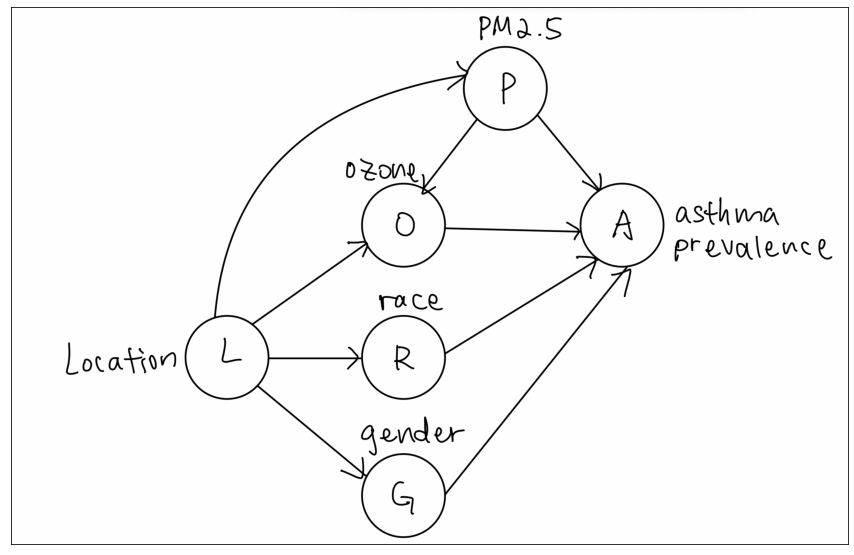

In [141]:
import matplotlib.image as mpimg
plt.figure(figsize=(15, 12))
img = mpimg.imread('dag.png')
imgplot = plt.imshow(img)
imgplot.axes.get_xaxis().set_visible(False)
imgplot.axes.get_yaxis().set_visible(False)

Here we see that both race and gender act as confounding variables for asthma prevalence. We want to control for both. However, since race and gender are mutually exclusive, we fit separate linear regression.
Thus, we examine the effect of PM2.5 on asthma prevalence by controlling for either race or gender.

### Model Setup
Assuming our DAG is correct, we set up the model as follows:

- Treatment variable Z: Ozone level
- Outcome variable Y: Age-adjusted Prevalence of Asthma
- Confounders: location, gender/race, PM2.5
- We assume that the unconfoundedness assumption holds. In other words, location, gender/race and PM2.5 are the only confounders in this problem.
- There is no collider in the dataset


### The Unconfoundedness Assumption
- The unconfoundedness assumption says loosely that all the variables affecting both the treatment T and the outcome Y are observed and can be controlled for.
- Since Year is not a confounding variable and we used age-adjusted prevalence to account for the effect of age on asthma prevalence, we assume unconfoundedness by controlling for all other observed variables (Location, Gender/Race, PM2.5)


### Here are some methods we would use in this section.

In [142]:
### This function below is adapted from Lab7
def fit_OLS_model(df, target_variable, explanatory_variables, intercept = False):
    """
    Fits an OLS model from data.
    
    Inputs:
        df: pandas DataFrame
        target_variable: string, name of the target variable
        explanatory_variables: list of strings, names of the explanatory variables
        intercept: bool, if True add intercept term
    Outputs:
        fitted_model: model containing OLS regression results
    """
    
    target = df[target_variable]
    inputs = df[explanatory_variables]
    if intercept:
        inputs = sm.add_constant(inputs)
    
    fitted_model = sm.OLS(target, inputs).fit()
    return(fitted_model)

In [143]:
### This function below is adapted from Lab8
def RMSE(true_vals, predicted_vals):
    """
    Return the mean squared error
    
    Inputs:
        true_vals: array of true labels
        predicted_vals: array labels predicted from the data
    Output:
        float, mean squared error of the predicted values
    """
    return np.mean((true_vals - predicted_vals) ** 2) ** 0.5

In [144]:
def encode_and_bind(original_dataframe, feature_to_encode):
    """
    One-hot encoding for deature
    """
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

## Part A. We first try controlling for confounding variables by fitting a GLM model.

### a) We start by first conducting one-hot encoding on race/gender/location

In [145]:
# One-hot encoding for race
prevalence_race_onehot = encode_and_bind(prevalence_race, 'Stratification')
prevalence_race_onehot = prevalence_race_onehot.rename(columns={'Stratification_BLK':'BLK','Stratification_HIS':'HIS',
                                                'Stratification_MRC':'MRC', 'Stratification_OTH':'OTH',
                                                'Stratification_WHT':'WHT'})
prevalence_race_onehot.head(5)

,Year,State,StateID,Prevalence,StratificationCategory,PM2.5,Ozone,BLK,HIS,MRC,OTH,WHT
1,2014,Alabama,1,9.5,RACE,11.025839,37.455517,0,0,0,0,1
2,2014,Colorado,8,9.1,RACE,6.737662,44.177632,0,0,0,1,0
3,2011,Colorado,8,15.5,RACE,6.438329,47.043940,0,0,1,0,0
4,2011,Arkansas,5,25.5,RACE,10.607418,41.012629,0,0,1,0,0
5,2012,Arkansas,5,8.9,RACE,9.948684,42.500444,1,0,0,0,0


In [146]:
# One-hot encoding for gender
prevalence_gender_onehot = encode_and_bind(prevalence_gender, 'Stratification')
prevalence_gender_onehot = prevalence_gender_onehot.rename(columns={'Stratification_GENF':'Female','Stratification_GENM':'Male'})
prevalence_gender_onehot.head(5)

,Year,State,StateID,Prevalence,StratificationCategory,PM2.5,Ozone,Female,Male
0,2013,Utah,49,7.2,GENDER,9.311432,41.073701,0,1
17,2014,Colorado,8,5.9,GENDER,6.737662,44.177632,0,1
24,2012,Colorado,8,10.7,GENDER,6.906790,47.597103,1,0
28,2012,Colorado,8,7.0,GENDER,6.906790,47.597103,0,1
31,2014,Colorado,8,10.9,GENDER,6.737662,44.177632,1,0


In [147]:
# One-hot encoding for location
prevalence_state_onehot = encode_and_bind(prevalence_final, 'State')
prevalence_state_onehot.head(5)

,Year,StateID,Prevalence,StratificationCategory,Stratification,PM2.5,Ozone,State_Alabama,State_Arizona,State_Arkansas,...,State_South Dakota,State_Tennessee,State_Texas,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming
0,2013,49,7.2,GENDER,GENM,9.311432,41.073701,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,2014,1,9.5,RACE,WHT,11.025839,37.455517,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2014,8,9.1,RACE,OTH,6.737662,44.177632,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2011,8,15.5,RACE,MRC,6.438329,47.043940,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2011,5,25.5,RACE,MRC,10.607418,41.012629,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [148]:
# One-hot both state and race
prevalence_race_state_onehot = encode_and_bind(prevalence_race_onehot, 'State')
prevalence_race_state_onehot.head()

,Year,StateID,Prevalence,StratificationCategory,PM2.5,Ozone,BLK,HIS,MRC,OTH,...,State_South Dakota,State_Tennessee,State_Texas,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming
1,2014,1,9.5,RACE,11.025839,37.455517,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2014,8,9.1,RACE,6.737662,44.177632,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2011,8,15.5,RACE,6.438329,47.043940,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2011,5,25.5,RACE,10.607418,41.012629,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,2012,5,8.9,RACE,9.948684,42.500444,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [149]:
# One-hot both state and gender
prevalence_gender_state_onehot = encode_and_bind(prevalence_gender_onehot, 'State')
prevalence_gender_state_onehot.head()

,Year,StateID,Prevalence,StratificationCategory,PM2.5,Ozone,Female,Male,State_Alabama,State_Arizona,...,State_South Dakota,State_Tennessee,State_Texas,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming
0,2013,49,7.2,GENDER,9.311432,41.073701,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
17,2014,8,5.9,GENDER,6.737662,44.177632,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
24,2012,8,10.7,GENDER,6.906790,47.597103,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,2012,8,7.0,GENDER,6.906790,47.597103,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
31,2014,8,10.9,GENDER,6.737662,44.177632,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### b) We now fit the linear regression models
Since we have panel data, we want to omit variable BLK, and Male to prevent perfect multicollinearity

#### i) We examine the casual effect of Ozone on age-adjusted asthma prevalence by controlling for location and PM2.5

We first control for location because according to our DAG, controlling for location satisfies **backdoor criterion** and can block every path to asthma prevalence (ie. gender/race) except the path from ozone to prevalence.\
We also control for PM2.5 because PM2.5 is a confounder in investigating the causal relationship between ozone and asthma prevalence.

In [150]:
selected_state_columns = ['Ozone','PM2.5','State_Arizona',
       'State_Arkansas', 'State_California', 'State_Colorado',
       'State_Connecticut', 'State_Delaware', 'State_District of Columbia',
       'State_Florida', 'State_Georgia', 'State_Idaho', 'State_Illinois',
       'State_Indiana', 'State_Iowa', 'State_Kansas', 'State_Kentucky',
       'State_Louisiana', 'State_Maine', 'State_Maryland',
       'State_Massachusetts', 'State_Michigan', 'State_Minnesota',
       'State_Mississippi', 'State_Missouri', 'State_Montana',
       'State_Nebraska', 'State_Nevada', 'State_New Hampshire',
       'State_New Jersey', 'State_New Mexico', 'State_New York',
       'State_North Carolina', 'State_North Dakota', 'State_Ohio',
       'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania',
       'State_Rhode Island', 'State_South Carolina', 'State_South Dakota',
       'State_Tennessee', 'State_Texas', 'State_Utah', 'State_Vermont',
       'State_Virginia', 'State_Washington', 'State_West Virginia',
       'State_Wisconsin', 'State_Wyoming']

In [151]:
model_prevalence_pm_loc = fit_OLS_model(prevalence_state_onehot, 'Prevalence', selected_state_columns, intercept = True)
print(model_prevalence_pm_loc.summary())

                            OLS Regression Results                            
Dep. Variable:             Prevalence   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     4.397
Date:                Sat, 11 Dec 2021   Prob (F-statistic):           6.56e-21
Time:                        13:03:15   Log-Likelihood:                -3560.1
No. Observations:                1313   AIC:                             7222.
Df Residuals:                    1262   BIC:                             7486.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



The p-value for the coefficient for ozone is very large, and the log-likelihood is also very large, indicating that this model is not ideal. Therefore, we will then control for race/gender in our analysis below.

#### ii) We examine the casual effect of Ozone on age-adjusted asthma prevalence by controlling for race and PM2.5

The model is in the following form: Prevalence = $\alpha$ + $\tau*Z$ + $b*$PM2.5 + $c*$HIS + $d*$MRC + $e*$OTH + $f*$WHT

In [152]:
# Omitting BLK variable (for panel data)
model_prevalence_pm_race = fit_OLS_model(prevalence_race_onehot, 'Prevalence', ['Ozone','PM2.5','HIS', 'MRC', 
                                                                             'OTH', 'WHT'], intercept = True)
print(model_prevalence_pm_race.summary())

                            OLS Regression Results                            
Dep. Variable:             Prevalence   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     108.6
Date:                Sat, 11 Dec 2021   Prob (F-statistic):           2.94e-97
Time:                        13:03:15   Log-Likelihood:                -1907.8
No. Observations:                 725   AIC:                             3830.
Df Residuals:                     718   BIC:                             3862.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.2845      2.101      7.276      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [153]:
model_prevalence_pm_race_no_intercept = fit_OLS_model(prevalence_race_onehot, 'Prevalence', 
                                                      ['Ozone',"PM2.5", 'HIS', 'MRC', 'OTH', 'WHT'])

In [154]:
model_prevalence_pm_race_predicted = model_prevalence_pm_race_no_intercept.predict(prevalence_race_onehot[[
                                                          'Ozone',"PM2.5",'HIS','MRC','OTH','WHT']]).values
err = RMSE(prevalence_race_onehot['Prevalence'].values, model_prevalence_pm_race_predicted)
err

3.4835520063555636

We see the model has a log-likelihood closer to 0 compared to the previous model and the coefficient for ozone is statistically significant at 10% significance level.

#### iii) We examine the casual effect of Ozone on age-adjusted asthma prevalence by controlling for gender and PM2.5

The model is in the following form: Prevalence = $\alpha$ + $\tau*Z + b*PM2.5 + c*Female$

In [155]:
model_prevalence_pm_gender = fit_OLS_model(prevalence_gender_onehot, 'Prevalence', ['Ozone','PM2.5', 'Female'], 
                                           intercept = True)
print(model_prevalence_pm_gender.summary())

                            OLS Regression Results                            
Dep. Variable:             Prevalence   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     409.4
Date:                Sat, 11 Dec 2021   Prob (F-statistic):          8.49e-120
Time:                        13:03:16   Log-Likelihood:                -686.62
No. Observations:                 392   AIC:                             1381.
Df Residuals:                     388   BIC:                             1397.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0962      1.181     10.246      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



The Log-likelihood is even closer to 0. And the coefficient of Ozone is statistically significant in both linear regression models with a p-value less than 0.05.

**Result:** There is casual relationship between ozone and age-adjusted prevalence rate of asthma. The last two model suggest that one unit increase in the ozone level causes age-adjusted prevalence to decrease by 0.07 and 0.11 respectively.

## Part B. We try controlling for confounding variables by Inverse Propensity Weighting.

### Assigning Treatment and Control
To apply IPW, we need to deternmine a binary treatment variable. We accomplish this by calculating the difference of PM2.5 and ozone levels between 2011 and 2014. By setting a threshold of -2, we divide the dataset into treatment and control groups that have approximately the same size.

In [156]:
prevalence_2011 = prevalence_final[prevalence_final['Year'] == 2011]
prevalence_2014 = prevalence_final[prevalence_final['Year'] == 2014]
prevalence_2014[prevalence_2014['State'] == 'Missouri']

,Year,State,StateID,Prevalence,StratificationCategory,Stratification,PM2.5,Ozone
452,2014,Missouri,29,9.6,RACE,WHT,9.425226,37.530147
556,2014,Missouri,29,11.6,RACE,BLK,9.425226,37.530147
955,2014,Missouri,29,9.8,OVERALL,OVR,9.425226,37.530147
1144,2014,Missouri,29,12.0,GENDER,GENF,9.425226,37.530147
1205,2014,Missouri,29,7.4,GENDER,GENM,9.425226,37.530147
1282,2014,Missouri,29,10.6,RACE,OTH,9.425226,37.530147


In [157]:
prevalence_2011_2014 = pd.merge(prevalence_2011, prevalence_2014, how='left', on=['State','StateID', 'StratificationCategory', 
                                                                                  'Stratification'])
p = prevalence_2011_2014.rename(columns={'PM2.5_x':'PM2.5_2011','PM2.5_y':'PM2.5_2014',
                                        'Ozone_x':'Ozone_2011', 'Ozone_y':'Ozone_2014',
                                        'Prevalence_x':'Prevalence_2011', 'Prevalence_y':'Prevalence_2014'})
p['Prevalence_diff'] = p['Prevalence_2014'] - p['Prevalence_2011']
p['Ozone_diff'] = p['Ozone_2014'] - p['Ozone_2011']
p['PM2.5_diff'] = p['PM2.5_2014'] - p['PM2.5_2011']
p.head()

,Year_x,State,StateID,Prevalence_2011,StratificationCategory,Stratification,PM2.5_2011,Ozone_2011,Year_y,Prevalence_2014,PM2.5_2014,Ozone_2014,Prevalence_diff,Ozone_diff,PM2.5_diff
0,2011,Colorado,8,15.5,RACE,MRC,6.438329,47.043940,2014.0,16.6,6.737662,44.177632,1.1,-2.866308,0.299333
1,2011,Arkansas,5,25.5,RACE,MRC,10.607418,41.012629,2014.0,30.3,9.865337,36.892805,4.8,-4.119824,-0.742082
2,2011,Connecticut,9,20.1,RACE,MRC,9.250752,37.700337,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011,California,6,6.9,RACE,OTH,10.424960,39.981360,2014.0,5.5,10.705496,41.944996,-1.4,1.963636,0.280536
4,2011,Colorado,8,11.1,RACE,OTH,6.438329,47.043940,2014.0,9.1,6.737662,44.177632,-2.0,-2.866308,0.299333


In [158]:
selected_col = ['State', 'StateID', 'StratificationCategory', 'Stratification', 'Prevalence_diff', 'Ozone_diff', 'PM2.5_diff']
p_final = p[selected_col]
p_final['Ozone_treatment'] = p_final['Ozone_diff'].apply(lambda x: 1 if x > -2 else 0)
p_final.head(5)

,State,StateID,StratificationCategory,Stratification,Prevalence_diff,Ozone_diff,PM2.5_diff,Ozone_treatment
0,Colorado,8,RACE,MRC,1.1,-2.866308,0.299333,0
1,Arkansas,5,RACE,MRC,4.8,-4.119824,-0.742082,0
2,Connecticut,9,RACE,MRC,NaN,NaN,NaN,0
3,California,6,RACE,OTH,-1.4,1.963636,0.280536,1
4,Colorado,8,RACE,OTH,-2.0,-2.866308,0.299333,0


We decide to use gender/race PM2.5 to compute our propensity score instead of location because there will be 50 mores parameters if we perform one-hot encoding on location, which will affect the degree of freedom. Moreover, according to our analysis above, the model that used location has the most negative log-likelihood.

### 1) Propensity score controlling gender and PM2.5
We used logistic regression to assign propensity scores (adapted from labs)

In [159]:
# One-hot encoding of gender
p_gender = p_final[p_final['StratificationCategory'] == 'GENDER']
p_gender = encode_and_bind(p_gender, 'Stratification')

In [160]:
# Select useful columns for our analysis
cols = ['Ozone_treatment', 'State', 'StateID', 'StratificationCategory', 'Prevalence_diff', 'Stratification_GENF',
        'PM2.5_diff']
p_gender_edited = p_gender[cols]
p_gender_edited.head()

,Ozone_treatment,State,StateID,StratificationCategory,Prevalence_diff,Stratification_GENF,PM2.5_diff
21,1,California,6,GENDER,-1.3,0,0.280536
22,1,Connecticut,9,GENDER,-1.0,0,-1.051404
24,0,Alabama,1,GENDER,2.9,1,0.303445
28,1,California,6,GENDER,-0.1,1,0.280536
29,1,Connecticut,9,GENDER,-0.7,1,-1.051404


In [161]:
from sklearn.linear_model import LogisticRegression as LR 
lr = LR(penalty='none', max_iter=200, random_state=0)
y = p_gender_edited['Prevalence_diff']
z = p_gender_edited['Ozone_treatment']
x = np.array([i.tolist()[-2:] for i in p_gender_edited.values], dtype='float')
lr.fit(x, z)

LogisticRegression(max_iter=200, penalty='none', random_state=0)

In [162]:
def estimate_treatment_effect(model, X, Y, Z):
    ex = model.predict_proba(X)[:, 1]
    return np.mean(Z * Y / ex) - np.mean((1 - Z) * Y / (1 - ex))

Below is the propensity score distribution:

(array([ 4.,  8.,  8.,  8., 18., 28.,  8.,  8.,  4.,  4.]),
 array([0.4808014, 0.4867496, 0.4926978, 0.498646 , 0.5045942, 0.5105424,
        0.5164906, 0.5224388, 0.528387 , 0.5343352, 0.5402834]),
 <BarContainer object of 10 artists>)

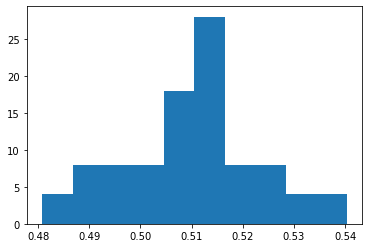

In [163]:
plt.hist(lr.predict_proba(x)[:, 1])

In [164]:
tau = estimate_treatment_effect(lr, x, y, z)
tau

-0.21882269835373558

**Result:** The estimated treatment effect is approximately -0.218, implying that ozone level has a negative causal effect on the asthma prevalence. This means that the differece in ozone level between 2014 and 2011 decreased asthma prevalence by -0.218.

### 2) Propensity score controlling race and PM2.5

In [165]:
p_race = p_final[p_final['StratificationCategory'] == 'RACE']
p_race = encode_and_bind(p_race, 'Stratification')
p_race = p_race.rename(columns={'Stratification_BLK':'BLK','Stratification_HIS':'HIS',
                                                'Stratification_MRC':'MRC', 'Stratification_OTH':'OTH',
                                                'Stratification_WHT':'WHT'})
p_race.columns

Index(['State', 'StateID', 'StratificationCategory', 'Prevalence_diff',
       'Ozone_diff', 'PM2.5_diff', 'Ozone_treatment', 'BLK', 'HIS', 'MRC',
       'OTH', 'WHT'],
      dtype='object')

In [166]:
p_race_edited = p_race[['Ozone_treatment', 'State', 'StateID', 'StratificationCategory', 'Prevalence_diff',
                        'Ozone_diff', 'PM2.5_diff', 'HIS', 'MRC','OTH', 'WHT']]
p_race_edited = p_race_edited.dropna()
p_race_edited.head()

,Ozone_treatment,State,StateID,StratificationCategory,Prevalence_diff,Ozone_diff,PM2.5_diff,HIS,MRC,OTH,WHT
0,0,Colorado,8,RACE,1.1,-2.866308,0.299333,0,1,0,0
1,0,Arkansas,5,RACE,4.8,-4.119824,-0.742082,0,1,0,0
3,1,California,6,RACE,-1.4,1.963636,0.280536,0,0,1,0
4,0,Colorado,8,RACE,-2.0,-2.866308,0.299333,0,0,1,0
5,1,Connecticut,9,RACE,-1.8,0.411285,-1.051404,1,0,0,0


In [167]:
y = p_race_edited['Prevalence_diff']
z = p_race_edited['Ozone_treatment']
x = np.array([i.tolist()[-5:] for i in p_race_edited.values], dtype='float')
lr.fit(x, z)

LogisticRegression(max_iter=200, penalty='none', random_state=0)

(array([ 6., 26., 15., 47., 27., 15.,  1.,  2., 13., 13.]),
 array([0.41008598, 0.43620732, 0.46232866, 0.48845   , 0.51457134,
        0.54069268, 0.56681402, 0.59293536, 0.6190567 , 0.64517804,
        0.67129938]),
 <BarContainer object of 10 artists>)

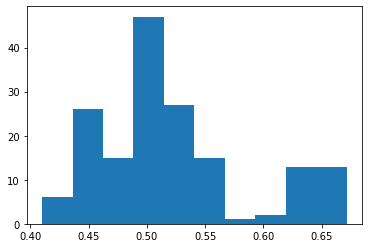

In [168]:
plt.hist(lr.predict_proba(x)[:, 1])

In [169]:
tau = estimate_treatment_effect(lr, x, y, z)
tau

0.13236411917522636

**Result:** The estimated treatment effect is approximately 0.132, implying that ozone level has a positive causal effect on the asthma prevalence. This means that the differece in ozone level between 2014 and 2011 increased asthma prevalence by 0.132.

According to our research on scientific studies, we believe that the ATE calculated when we controlled for race and PM2.5 is more reliable. Moreover, location has more influence on race compared to gender. And acoording to our scatterplot on prevalence and ozone (seperated by race), race seems to have a greater effect on ozone level compared to gender, therefore it is be a better variable to be controlled to invetigate ATE.

## Results

| Method | Variables Controlled | Ozone effect on asthma prevalence | Quality of result (Log-likelihood) |
|--------|----------------------|-------------|------------|
| Linear Regression |  Location & PM2.5  | -0.0208 (p-val = 0.823) |  -3560   |
| Linear Regression | Race & PM2.5 | -0.0778 (p-val = 0.067)| -1907.8 |
| Linear Regression | Gender & PM2.5 | -0.115 (p-val = 0.0) |-686.62|
| IPW | Gender & PM2.5 | ATE = -0.218 |nan|
| IPW |Race & PM2.5| ATE = 0.132 |nan|

Assume unconfoundedness,
1. According to our linear regression model, one unit increase in the ozone level causes prevalence to decrease by approximatrly 0.1
2. According to our Inverse Propensity Weighting method on gender and PM2.5, one unit increase in ozone level difference decrease the asthma prevalence difference by 0.218
3. According to our Inverse Propensity Weighting method on race and PM2.5, one unit increase in ozone level difference increase the asthma prevalence difference by 0.132

- According to our DAG, controlling for location satisfies the backdoor criterion. However, unsatisfying results promoted us to further explore controlling for either gender or race.
- The fact that most of our model suggests that ozone level has a negative causal effect on asthma prevalance seems counterintuitive becuase higher ozone level is irritating to the lungs and airways and therefore is more likely to trigger asthma.
- Therefore, we suspect that our models are not reliable primarily because we lack data on other possible confounders such as smoking and individual health conditions (i.e. obesity, family history, allergies).

## Discussion

Limitations:
1. There may be other confounders such as health condition/smoking that may affect the age-adjusted prevalence of asthma. However, we don't have these data and therefore can't control for them in our model. This implies that the unconfoundedness assumption may be violated.
2. Location, gender and race may not be good confounders to be controlled for in this model.
3. Inverse Propensity Weighting may not be a good method to investigate causal relationship between ozone level and asthma prevalence becuase our treatment versus control are not naturally binary variables.
4. Linear regression model may not be a good model to use in this case because we are not sure that ozone level, asthma prevalence and other confounding variables has a linear relationship.
5. After our research, we found out that temperature directly influences ozone production. Thus, to better analyze the causal impact of the ozone level on the prevalence of asthma, we should examine the data seasonally. However, our original data only contains yearly prevalence of asthma which forces us to average the ozone level over a year in correspondence. Thus, the fluctuations of ozone level are eliminated. Hence it makes sense that we can't find a clear causal relationship.

Other data that might be useful:
1. Average age/proportion of participates that smoke to be used as controlled variables in the model
2. Possible instrumental variables for ozone level such as temperature
3. Monthly asthma data to analyze the causal impact over a season
4. Other numerical data about state eg.the number of factories in each state

We are not confident that there is a causal relationship between ozone level and asthma because there are so many confounders that need to be controlled for in order to accurately estimate the causal effect. 

# Research Question 2: Given the selected features, build a model that can predict the age-adjusted prevalence of Asthma.

## Assumptions

**GLMs**
- When using glms, we assume that all variables included form a linear relationship. 
- We choose the gamma family for modeling the relationships between selected variables and asthma prevalence because the latter is a non-negative, continuous variable

**Non-parametric method**
- We assume our data is not linearly separable
- Decision tree & Random forests: We have many categorical features, which is good for decision tree & random forest modeling.
- k-Nearest Neighbors: k-Nearest Neighbors makes no assumptions whatsoever about the data (other than that the training data is a representative sample).


We want to try all methods we learnt in lectures to find out the best model by comparing MSE of every model. 

## Overall Method Description

- Variables for prediction: Asthma prevalence.
- Features used: Location, Gender/Race, PM2.5, Ozone.

**Justification:** From our DAG and results from research question 1, we suspect that asthma prevalence is influenced by all features listed above.\
We want to divide our dataset into training and test set for evaluating accuracy of models. Since race and gender are recorded as mutually exclusive variables in the dataset, we contruct separate models that takes them into account respectively.

## Train-test split

### Train-test split for race as stratification

In [170]:
prevalence_race_state_onehot2 =  prevalence_race_state_onehot.rename(columns={'PM2.5':'PM25'})
prevalence_race_state_onehot3 = prevalence_race_state_onehot2[['Prevalence','PM25',
       'Ozone', 'BLK', 'HIS', 'MRC', 'OTH', 'WHT', 'State_Alabama',
       'State_Arizona', 'State_Arkansas', 'State_California', 'State_Colorado',
       'State_Connecticut', 'State_Delaware', 'State_District of Columbia',
       'State_Florida', 'State_Georgia', 'State_Idaho', 'State_Illinois',
       'State_Indiana', 'State_Iowa', 'State_Kansas', 'State_Kentucky',
       'State_Louisiana', 'State_Maine', 'State_Maryland',
       'State_Massachusetts', 'State_Michigan', 'State_Minnesota',
       'State_Mississippi', 'State_Missouri', 'State_Montana',
       'State_Nebraska', 'State_Nevada', 'State_New Hampshire',
       'State_New Jersey', 'State_New Mexico', 'State_New York',
       'State_North Carolina', 'State_North Dakota', 'State_Ohio',
       'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania',
       'State_Rhode Island', 'State_South Carolina', 'State_South Dakota',
       'State_Tennessee', 'State_Texas', 'State_Utah', 'State_Vermont',
       'State_Virginia', 'State_Washington', 'State_West Virginia',
       'State_Wisconsin', 'State_Wyoming']]
prevalence_race_state_onehot3 = prevalence_race_state_onehot3.rename(columns={
        'State_District of Columbia':'State_District_of_Columbia','State_New Hampshire':'State_New_Hampshire',
        'State_New Jersey':'State_New_Jersey', 'State_New Mexico':'State_New_Mexico', 'State_New York':'State_New_York',
        'State_North Carolina':'State_North_Carolina', 'State_North Dakota':'State_North_Dakota',
        'State_Rhode Island':'State_Rhode_Island', 'State_South Carolina':'State_South_Carolina', 
        'State_South Dakota':'State_South_Dakota', 'State_West Virginia':'State_West_Virginia'})

In [171]:
from sklearn.model_selection import train_test_split
train1, test1 = train_test_split(prevalence_race_state_onehot3, test_size=0.3, random_state=102)

In [172]:
train1.head(5)

,Prevalence,PM25,Ozone,BLK,HIS,MRC,OTH,WHT,State_Alabama,State_Arizona,...,State_South_Dakota,State_Tennessee,State_Texas,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West_Virginia,State_Wisconsin,State_Wyoming
768,11.5,9.682943,38.442977,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
525,14.1,9.795626,41.722261,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
817,13.0,8.855819,36.626529,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
573,9.0,8.246603,41.636938,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
484,25.0,10.178120,39.612826,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Train-test split for gender as stratification

In [173]:
prevalence_gender_state_onehot2 =  prevalence_gender_state_onehot.rename(columns={'PM2.5':'PM25'})
prevalence_gender_state_onehot3 = prevalence_gender_state_onehot2[['Prevalence','PM25',
       'Ozone', 'Female','Male', 'State_Alabama',
       'State_Arizona', 'State_Arkansas', 'State_California', 'State_Colorado',
       'State_Connecticut', 'State_Delaware', 'State_District of Columbia',
       'State_Florida', 'State_Georgia', 'State_Idaho', 'State_Illinois',
       'State_Indiana', 'State_Iowa', 'State_Kansas', 'State_Kentucky',
       'State_Louisiana', 'State_Maine', 'State_Maryland',
       'State_Massachusetts', 'State_Michigan', 'State_Minnesota',
       'State_Mississippi', 'State_Missouri', 'State_Montana',
       'State_Nebraska', 'State_Nevada', 'State_New Hampshire',
       'State_New Jersey', 'State_New Mexico', 'State_New York',
       'State_North Carolina', 'State_North Dakota', 'State_Ohio',
       'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania',
       'State_Rhode Island', 'State_South Carolina', 'State_South Dakota',
       'State_Tennessee', 'State_Texas', 'State_Utah', 'State_Vermont',
       'State_Virginia', 'State_Washington', 'State_West Virginia',
       'State_Wisconsin', 'State_Wyoming']]
prevalence_gender_state_onehot3 = prevalence_gender_state_onehot3.rename(columns={
        'State_District of Columbia':'State_District_of_Columbia','State_New Hampshire':'State_New_Hampshire',
        'State_New Jersey':'State_New_Jersey', 'State_New Mexico':'State_New_Mexico', 'State_New York':'State_New_York',
        'State_North Carolina':'State_North_Carolina', 'State_North Dakota':'State_North_Dakota',
        'State_Rhode Island':'State_Rhode_Island', 'State_South Carolina':'State_South_Carolina', 
        'State_South Dakota':'State_South_Dakota', 'State_West Virginia':'State_West_Virginia'})



In [174]:
from sklearn.model_selection import train_test_split

train2, test2 = train_test_split(prevalence_gender_state_onehot3, test_size=0.3, random_state=102)

In [175]:
train2.head()

,Prevalence,PM25,Ozone,Female,Male,State_Alabama,State_Arizona,State_Arkansas,State_California,State_Colorado,...,State_South_Dakota,State_Tennessee,State_Texas,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West_Virginia,State_Wisconsin,State_Wyoming
1210,13.7,8.646459,37.324566,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1025,8.6,8.652694,37.014326,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1055,7.4,9.614984,41.619303,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1215,12.7,8.405081,39.384253,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
352,7.1,6.507668,44.619976,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 1. Asthma prevalence prediction using Race, State, Ozone, and PM2.5

### a) Prediction with Frequentist GLM

In [176]:
import statsmodels.formula.api as smf

In [177]:
model_race_state_gamma = smf.glm(formula='Prevalence ~ PM25 + Ozone + HIS + MRC + OTH + WHT + State_Arizona\
                           + State_Arkansas + State_California + State_Colorado + State_Connecticut \
                           + State_Delaware + State_District_of_Columbia + State_Florida + State_Georgia\
                           + State_Idaho + State_Illinois + State_Indiana + State_Iowa + State_Kansas\
                           + State_Kentucky + State_Louisiana + State_Maine + State_Maryland + State_Massachusetts\
                           + State_Michigan + State_Minnesota + State_Mississippi + State_Missouri + State_Montana\
                           + State_Nebraska + State_Nevada + State_New_Hampshire + State_New_Jersey + State_New_Mexico\
                           + State_New_York + State_North_Carolina + State_North_Dakota + State_Ohio + State_Oklahoma\
                           + State_Oregon + State_Pennsylvania + State_Rhode_Island + State_South_Carolina\
                           + State_South_Dakota + State_Tennessee + State_Texas + State_Utah + State_Vermont\
                           + State_Virginia + State_Washington + State_West_Virginia + State_Wisconsin + State_Wyoming',
                           data=train1, family=sm.families.Gamma())

/opt/conda/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning:

The inverse_power link function does not respect the domain of the Gamma family.



In [178]:
gamma_results_race_state = model_race_state_gamma.fit()
print(gamma_results_race_state.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             Prevalence   No. Observations:                  507
Model:                            GLM   Df Residuals:                      452
Model Family:                   Gamma   Df Model:                           54
Link Function:          inverse_power   Scale:                        0.062805
Method:                          IRLS   Log-Likelihood:                -1189.0
Date:                Sat, 11 Dec 2021   Deviance:                       29.110
Time:                        13:03:17   Pearson chi2:                     28.4
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [179]:
print("Training set error for GLM with Gamma family (race + state):", RMSE(train1['Prevalence'],gamma_results_race_state.predict(train1)))
print("Test set error for GLM with Gamma family (race + state):    ", RMSE(test1['Prevalence'],gamma_results_race_state.predict(test1)))

Training set error for GLM with Gamma family (race + state): 2.727772327836729
Test set error for GLM with Gamma family (race + state):     3.2905275623603294


**Quick Summary:** 
- Holding other variable constant, increasing one uint of ozone level will decrease 0.005 unit of asthma prevalence for black people in state Alabama
- This model is not as satisfying becasue it has a log-likelihood of -1189.0 which is far from 0. It's deviance and chi-square stats are far from 452 (i.e. n - p).

**Uncertainty?**

In [180]:
def bootstrap_1d(samples, B=1000, fnc=np.mean):
    theta_boot = np.zeros(shape=(B,))
    for b in range(B):
        bootstrap_samples = rnd.choice(samples, N)
        theta_boot[b] = fnc(bootstrap_samples)
        
    return theta_boot

In [181]:
import numpy.random as rnd
import scipy.stats as st

mu = np.mean(test1['Prevalence'])
sigma = np.std(test1['Prevalence'])
N = 10
samples = test1['Prevalence']

X_grid = np.linspace(-1.5,1.5,100)

mu_boot = bootstrap_1d(samples, fnc=np.mean)

st.t.interval(alpha=0.95, df=len(mu_boot)-1, loc=np.mean(mu_boot), scale=st.sem(mu_boot))

(10.766283723266026, 10.938176276733971)

### b) Prediction with non-parametric methods

#### 1) Decision Tree

In [182]:
from sklearn.tree import DecisionTreeRegressor

selected_X_column = ['PM25', 'Ozone', 'BLK', 'HIS', 'MRC', 'OTH','WHT', 'State_Alabama', 'State_Arizona', 
                     'State_Arkansas','State_California', 'State_Colorado', 'State_Connecticut','State_Delaware', 
                     'State_District_of_Columbia', 'State_Florida','State_Georgia', 'State_Idaho', 'State_Illinois', 
                     'State_Indiana', 'State_Iowa', 'State_Kansas', 'State_Kentucky', 'State_Louisiana','State_Maine',
                     'State_Maryland', 'State_Massachusetts','State_Michigan', 'State_Minnesota', 'State_Mississippi',
                     'State_Missouri', 'State_Montana', 'State_Nebraska', 'State_Nevada','State_New_Hampshire', 
                     'State_New_Jersey', 'State_New_Mexico','State_New_York', 'State_North_Carolina', 'State_North_Dakota',
                     'State_Ohio', 'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania','State_Rhode_Island', 
                     'State_South_Carolina', 'State_South_Dakota','State_Tennessee', 'State_Texas', 'State_Utah', 
                     'State_Vermont','State_Virginia', 'State_Washington', 'State_West_Virginia','State_Wisconsin', 
                     'State_Wyoming']

tree_model = DecisionTreeRegressor()
X = train1[selected_X_column]
y = train1["Prevalence"]
tree_model.fit(X,y)

train1["tree_pred"] = tree_model.predict(X) 
test1["tree_pred"] = tree_model.predict(test1[selected_X_column])

In [183]:
train_rmse = np.mean((train1["tree_pred"] - train1["Prevalence"]) ** 2) ** 0.5
test_rmse = np.mean((test1["tree_pred"] - test1["Prevalence"]) ** 2) ** 0.5

print("Training set error for decision tree:", train_rmse)
print("Test set error for decision tree:    ", test_rmse)

Training set error for decision tree: 0.0
Test set error for decision tree:     4.202827794222589


As we learned in class, decision tree can reach MSE of 0 for the training set. </br>
Decision Tree also produces an acceptable MSE, yet it's a little worse than linear regression model. </br>

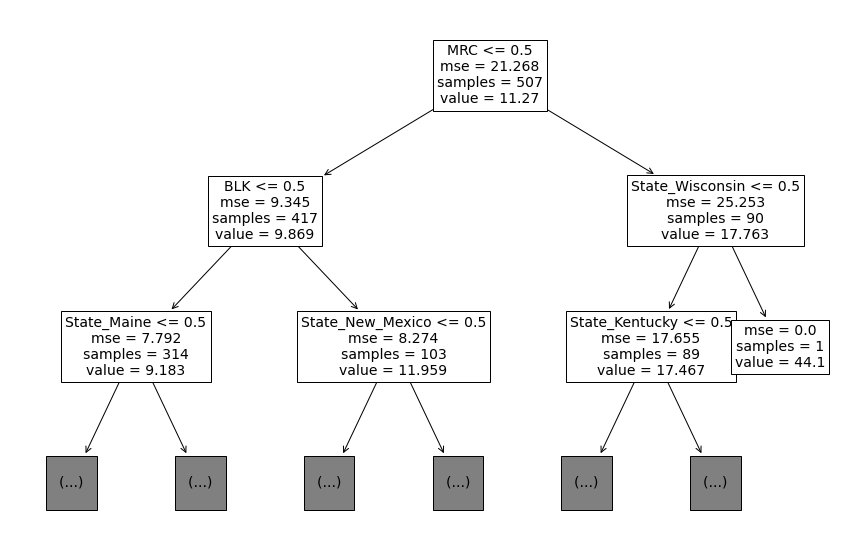

In [184]:
from sklearn.tree import plot_tree
plt.figure(figsize=(15, 10))
plot_tree(tree_model, max_depth=2, fontsize=14,feature_names=selected_X_column);

**Quick Summary:** While decision trees are hard to interpret, we see a first attempt in dividing the data at BLK <= 0.5 and State_Wiscosin <= 0.5

#### 2) Random Forest

In [185]:
from sklearn.ensemble import RandomForestRegressor

forest_model = RandomForestRegressor(max_features=1)
forest_model.fit(X,y) 

train1["forest_pred"] = forest_model.predict(X) 
test1["forest_pred"] = forest_model.predict(test1[selected_X_column]) 

In [186]:
train_rmse = np.mean((train1["forest_pred"] - train1["Prevalence"]) ** 2) ** 0.5
test_rmse = np.mean((test1["forest_pred"] - test1["Prevalence"]) ** 2) ** 0.5

print("Training set error for random forest:", train_rmse)
print("Test set error for random forest:    ", test_rmse)

Training set error for random forest: 1.2076388657945365
Test set error for random forest:     3.1770676618152627


**Quick Summary:** Random Forests are hard to interpret. It does better than decision tree.

#### 3) k-nearest neighbors

In [187]:
from sklearn import neighbors
k_val= np.arange(2, 20)
knn_train_rmse=[]
knn_test_rmse=[]
for k in k_val:
    knn=neighbors.KNeighborsRegressor(n_neighbors=k)
    knn.fit(X,y)
    train1["knn_pred"] = knn.predict(X) 
    test1["knn_pred"] = knn.predict(test1[selected_X_column]) 
    train_rmse = RMSE(train1["Prevalence"],train1["knn_pred"])
    test_rmse = RMSE(test1["Prevalence"],test1["knn_pred"])
    knn_train_rmse.append(train_rmse)
    knn_test_rmse.append(test_rmse)

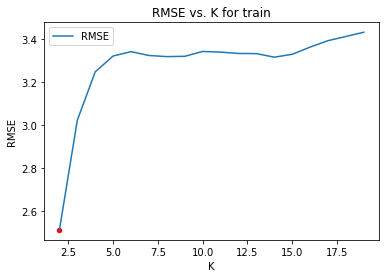

In [188]:
df=pd.DataFrame({'RMSE':knn_train_rmse, "K":k_val})
ax = df.plot(x='K')

(df.loc[[df['RMSE'].idxmin()]]
   .plot.scatter(x='K', y='RMSE',
                 color='r', ax=ax)
);

plt.title("RMSE vs. K for train");
plt.xlabel("K");
plt.ylabel("RMSE");

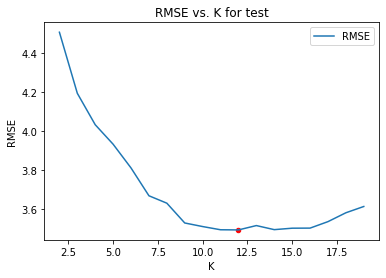

In [189]:
df=pd.DataFrame({'RMSE':knn_test_rmse, "K":k_val})
ax = df.plot(x='K')

df.loc[[df['RMSE'].idxmin()]].plot.scatter(x='K', y='RMSE',color='r', ax=ax);

plt.title("RMSE vs. K for test");
plt.xlabel("K");
plt.ylabel("RMSE");

From the above plot, we know that K = 12 generates the lowest RMSE for our test set.

In [190]:
# Show train RMSE and test RMSE when K = 12
KN_model = neighbors.KNeighborsRegressor(n_neighbors=12)
KN_model.fit(X,y)
train1["knn_pred"] = KN_model.predict(X) 
test1["knn_pred"] = KN_model.predict(test1[selected_X_column]) 
train_rmse = RMSE(train1["Prevalence"],train1["knn_pred"])
test_rmse = RMSE(test1["Prevalence"],test1["knn_pred"])

print("Training set error for K-Nearest Neighbor with K=12:", train_rmse)
print("Test set error for K-Nearest Neighbor with K=12:    ", test_rmse)

Training set error for K-Nearest Neighbor with K=12: 3.333599533256242
Test set error for K-Nearest Neighbor with K=12:     3.4936623029354297


**Quick Summary:** 
K-NN performs worse than GLM.

## 2. Asthma prevalence prediction using Gender, State, Ozone, and PM2.5

### a) Frequentist GLM with Gamma family

In [191]:
model_gender_state_gamma = smf.glm(formula='Prevalence ~ PM25 + Ozone + Female + State_Arizona\
                           + State_Arkansas + State_California + State_Colorado + State_Connecticut \
                           + State_Delaware + State_District_of_Columbia + State_Florida + State_Georgia\
                           + State_Idaho + State_Illinois + State_Indiana + State_Iowa + State_Kansas\
                           + State_Kentucky + State_Louisiana + State_Maine + State_Maryland + State_Massachusetts\
                           + State_Michigan + State_Minnesota + State_Mississippi + State_Missouri + State_Montana\
                           + State_Nebraska + State_Nevada + State_New_Hampshire + State_New_Jersey + State_New_Mexico\
                           + State_New_York + State_North_Carolina + State_North_Dakota + State_Ohio + State_Oklahoma\
                           + State_Oregon + State_Pennsylvania + State_Rhode_Island + State_South_Carolina\
                           + State_South_Dakota + State_Tennessee + State_Texas + State_Utah + State_Vermont\
                           + State_Virginia + State_Washington + State_West_Virginia + State_Wisconsin + State_Wyoming',
                           data=train2, family=sm.families.Gamma())

/opt/conda/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning:

The inverse_power link function does not respect the domain of the Gamma family.



In [192]:
gaussian_results_gender_state_gamma = model_gender_state_gamma.fit()
print(gaussian_results_gender_state_gamma.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             Prevalence   No. Observations:                  274
Model:                            GLM   Df Residuals:                      222
Model Family:                   Gamma   Df Model:                           51
Link Function:          inverse_power   Scale:                       0.0091887
Method:                          IRLS   Log-Likelihood:                -321.07
Date:                Sat, 11 Dec 2021   Deviance:                       2.1310
Time:                        13:03:20   Pearson chi2:                     2.04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [193]:
print("Training set error for GLM with Gamma family:", RMSE(train2['Prevalence'],gaussian_results_gender_state_gamma.predict(train2)))
print("Test set error for GLM with Gamma family:    ", RMSE(test2['Prevalence'],gaussian_results_gender_state_gamma.predict(test2)))

Training set error for GLM with Gamma family: 0.7192010643524652
Test set error for GLM with Gamma family:     0.9929286779923532


**Quick Summary:**
- Holding other variable constant, increasing one uint of ozone level will increase 0.0006 unit of asthma prevalence for black people in state Alabama.
- This model is more satisfying than using race as stratification becasue it has a log-likelihood of -321.07 which is closer 0. However, it's deviance and chi-square stats are still far from 222(i.e. n - p).


### b) Prediction with non-parametric methods

#### 1) Decision Tree

In [196]:
from sklearn.tree import DecisionTreeRegressor

selected_X_column_gender = ['PM25', 'Ozone', 'Female', 'Male','State_Alabama', 'State_Arizona', 'State_Arkansas', 
                            'State_California','State_Colorado', 'State_Connecticut', 'State_Delaware',
                            'State_District_of_Columbia', 'State_Florida', 'State_Georgia','State_Idaho', 
                            'State_Illinois', 'State_Indiana', 'State_Iowa','State_Kansas', 'State_Kentucky', 
                            'State_Louisiana', 'State_Maine','State_Maryland', 'State_Massachusetts', 'State_Michigan',
                            'State_Minnesota', 'State_Mississippi', 'State_Missouri','State_Montana', 'State_Nebraska', 
                            'State_Nevada','State_New_Hampshire', 'State_New_Jersey', 'State_New_Mexico',
                            'State_New_York', 'State_North_Carolina', 'State_North_Dakota','State_Ohio', 'State_Oklahoma', 
                            'State_Oregon', 'State_Pennsylvania','State_Rhode_Island', 'State_South_Carolina', 
                            'State_South_Dakota','State_Tennessee', 'State_Texas', 'State_Utah', 'State_Vermont',
                            'State_Virginia', 'State_Washington', 'State_West_Virginia','State_Wisconsin', 'State_Wyoming']

X_gender = train2[selected_X_column_gender]
y_gender = train2["Prevalence"]
tree_model2 = DecisionTreeRegressor()
tree_model2.fit(X_gender,y_gender)

train2["tree_pred"] = tree_model2.predict(X_gender) 
test2["tree_pred"] = tree_model2.predict(test2[selected_X_column_gender])

train_rmse = np.mean((train2["tree_pred"] - train2["Prevalence"]) ** 2) ** 0.5
test_rmse = np.mean((test2["tree_pred"] - test2["Prevalence"]) ** 2) ** 0.5

print("Training set error for decision tree:", train_rmse)
print("Test set error for decision tree:    ", test_rmse)

Training set error for decision tree: 0.0
Test set error for decision tree:     1.2088305036028326


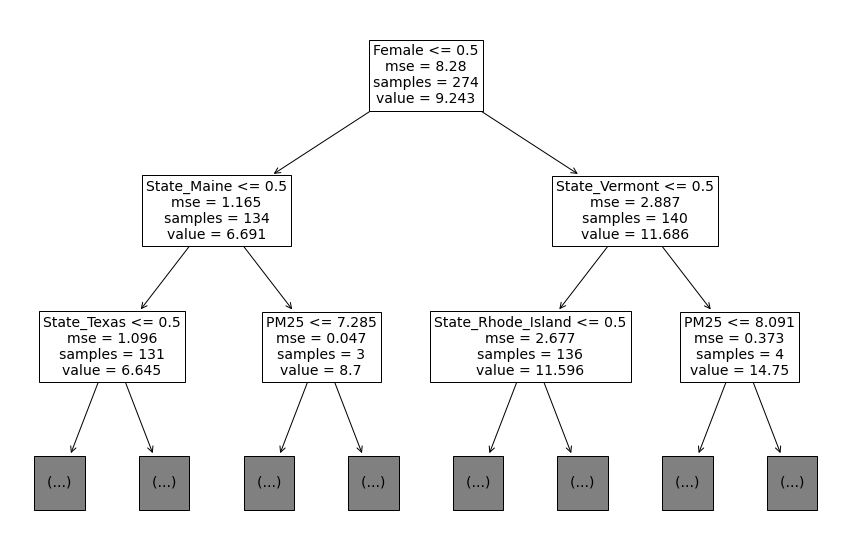

In [197]:
from sklearn.tree import plot_tree
plt.figure(figsize=(15, 10))
plot_tree(tree_model2, max_depth=2, fontsize=14,feature_names=selected_X_column_gender);

**Quick Summary:** While decision trees are hard to interpret, we see a first attempt in dividing the data at State_Maine <= 0.5 and State_Vermont <= 0.5

#### 2) Random Forest

In [198]:
from sklearn.ensemble import RandomForestRegressor

forest_model2 = RandomForestRegressor(max_features=1)
forest_model2.fit(X_gender,y_gender) 

train2["forest_pred"] = forest_model2.predict(X_gender) 
test2["forest_pred"] = forest_model2.predict(test2[selected_X_column_gender]) 

train_rmse = np.mean((train2["forest_pred"] - train2["Prevalence"]) ** 2) ** 0.5
test_rmse = np.mean((test2["forest_pred"] - test2["Prevalence"]) ** 2) ** 0.5

print("Training set error for random forest:", train_rmse)
print("Test set error for random forest:    ", test_rmse)

Training set error for random forest: 0.42675623679656866
Test set error for random forest:     1.134804181403922


**Quick Summary:** Random Forests are hard to interpret. It does better than decision tree.

### 3) k-nearest neighbors

In [199]:
from sklearn import neighbors
k_val= np.arange(2, 20)
knn_train_rmse2=[]
knn_test_rmse2=[]
for k in k_val:
    knn=neighbors.KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_gender,y_gender)
    train2["knn_pred"] = knn.predict(X_gender) 
    test2["knn_pred"] = knn.predict(test2[selected_X_column_gender]) 
    
    train_rmse = RMSE(train2["Prevalence"],train2["knn_pred"])
    test_rmse = RMSE(test2["Prevalence"],test2["knn_pred"])
    knn_train_rmse2.append(train_rmse)
    knn_test_rmse2.append(test_rmse)

Text(0, 0.5, 'RMSE')

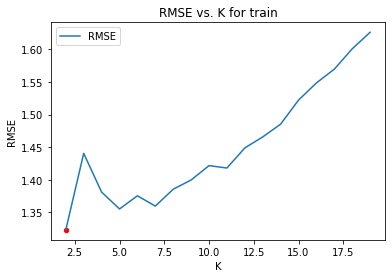

In [200]:
df=pd.DataFrame({'RMSE':knn_train_rmse2, "K":k_val});
ax = df.plot(x='K');
df.loc[[df['RMSE'].idxmin()]].plot.scatter(x='K', y='RMSE',color='r', ax=ax);

plt.title("RMSE vs. K for train")
plt.xlabel("K")
plt.ylabel("RMSE")

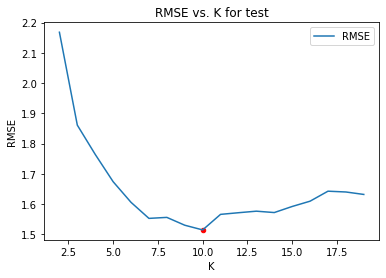

In [201]:
df=pd.DataFrame({'RMSE':knn_test_rmse2, "K":k_val})
ax = df.plot(x='K')
df.loc[[df['RMSE'].idxmin()]].plot.scatter(x='K', y='RMSE',color='r', ax=ax);

plt.title("RMSE vs. K for test");
plt.xlabel("K");
plt.ylabel("RMSE");

From the above plot, we know that K = 10 generates the lowest RMSE for our test set.

In [205]:
# Show train RMSE and test RMSE when K = 10
KN_model = neighbors.KNeighborsRegressor(n_neighbors=10)
KN_model.fit(X_gender,y_gender)
train2["knn_pred"] = KN_model.predict(X_gender) 
test2["knn_pred"] = KN_model.predict(test2[selected_X_column_gender]) 
train_rmse = RMSE(train2["Prevalence"],train2["knn_pred"])
test_rmse = RMSE(test2["Prevalence"],test2["knn_pred"])

print("Training set error for K-Nearest Neighbor with K=12:", train_rmse)
print("Test set error for K-Nearest Neighbor with K=12:    ", test_rmse)

Training set error for K-Nearest Neighbor with K=12: 1.42157528023396
Test set error for K-Nearest Neighbor with K=12:     1.5146451729695638


**Quick Summary:** K-NN performs worst this time.

## 3. Finally, let's see how Bayesian  model performs.

For Bayesian model, we encountered some technical issues when performing PyMC3: 
1. If we added too many features (like what we did before), the program would never finish running or the kernel will die. Thus, for simplicity, we only did Bayesian modeling for prevalence against ozone and PM25.
2. We know that the performance of Bayesian modeling depends on the choice of prior. However, when we tried to change our priors from time to time to choose the model with best performance, sometimes the program will be interrupted with no reason. Thus, our choice of prior is very limited.

The below portion is the **best result** we got for Bayesian modeling. 

In [206]:
import pymc3 as pm
from pymc3 import glm
import statsmodels.api as sm
import arviz

In [207]:
### This function below is adapted from LectureNotes
def show_posterior_predictive(
    trace, x=prevalence_race_state_onehot2['Ozone'], y=prevalence_race_state_onehot2['Prevalence'], num_lines=100,
    title="Posterior Predictive Distribution VS Observed Distribution for Asthma Prevalence"
):
    """
    Makes a posterior predictive plot for turbine data, 
    showing possible lines in gray
    """
    
    converter = lambda x, sample: np.exp(sample['Intercept'] + sample['Ozone'] * x)
    plt.figure(figsize=(6, 4), dpi=100)
    plt.semilogy(x, y, marker='o', linestyle='', label='Observed')
    plt.xlabel('Ozone level')
    plt.ylabel('Asthma Prevalence')
    pm.plot_posterior_predictive_glm(
        trace, samples=num_lines, eval=np.arange(25,50), 
        lm=converter, label='Predicted', alpha=0.4
    )
    plt.title(title)
    plt.legend()

We want to first determine the prior distributions for the coefficients of our variables.

In [208]:
prevalence_race_state_onehot2 =  prevalence_race_state_onehot.rename(columns={'PM2.5':'PM25'})
prevalence_race_state_onehot2['Log_Prevalence'] = np.log(prevalence_race_state_onehot2['Prevalence'])
prevalence_gender_state_onehot2 =  prevalence_gender_state_onehot.rename(columns={'PM2.5':'PM25'})
prevalence_gender_state_onehot2['Log_Prevalence'] = np.log(prevalence_gender_state_onehot2['Prevalence'])
prevalence_2011_onehot = prevalence_gender_state_onehot2[prevalence_gender_state_onehot2['Year'] == 2011]
prevalence_2011_onehot

,Year,StateID,Prevalence,StratificationCategory,PM25,Ozone,Female,Male,State_Alabama,State_Arizona,...,State_Tennessee,State_Texas,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming,Log_Prevalence
79,2011,6,6.1,GENDER,10.424960,39.981360,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1.808289
83,2011,9,7.1,GENDER,9.250752,37.700337,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1.960095
86,2011,1,9.6,GENDER,10.722394,41.170865,1,0,1,0,...,0,0,0,0,0,0,0,0,0,2.261763
116,2011,6,10.6,GENDER,10.424960,39.981360,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2.360854
121,2011,9,13.0,GENDER,9.250752,37.700337,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2.564949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1371,2011,35,7.5,GENDER,7.443219,44.718190,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2.014903
1375,2011,42,11.7,GENDER,10.387115,38.220020,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2.459589
1388,2011,23,16.2,GENDER,7.798412,36.067898,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2.785011
1394,2011,20,11.3,GENDER,9.842052,42.309627,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2.424803


In [209]:
model_2011 = smf.glm(formula='Log_Prevalence ~ PM25 + Ozone',
                           data=prevalence_2011_onehot, family=sm.families.Gaussian())
model_2011_results = model_2011.fit()
print(model_2011_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         Log_Prevalence   No. Observations:                   98
Model:                            GLM   Df Residuals:                       95
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                        0.099303
Method:                          IRLS   Log-Likelihood:                -24.363
Date:                Sat, 11 Dec 2021   Deviance:                       9.4338
Time:                        13:04:19   Pearson chi2:                     9.43
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7389      0.575      4.765      0.0

### 1) Now we fit a Bayesian GLM with derived priors excluding data from 2011

In [210]:
train_not2011, test_not2011 = train_test_split(prevalence_gender_state_onehot2[prevalence_gender_state_onehot2['Year'] != 2011], test_size=0.3, random_state=102)

In [211]:
with pm.Model() as gaussian_model:
    priors = {
        "Ozone": pm.Normal.dist(mu=-0.0108, sigma=0.012),
        "PM25": pm.Normal.dist(mu=-0.0167, sigma=0.027)
    }
    pm.GLM.from_formula('Log_Prevalence ~ Ozone + PM25', data = train_not2011, 
                         family = pm.glm.families.Normal(), priors = priors)
    # draw posterior samples
    gaussian_trace_standard = pm.sample(1000, cores=1, target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, PM25, Ozone, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 54 seconds.


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'Ozone'}>,
        <AxesSubplot:title={'center':'Ozone'}>],
       [<AxesSubplot:title={'center':'PM25'}>,
        <AxesSubplot:title={'center':'PM25'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

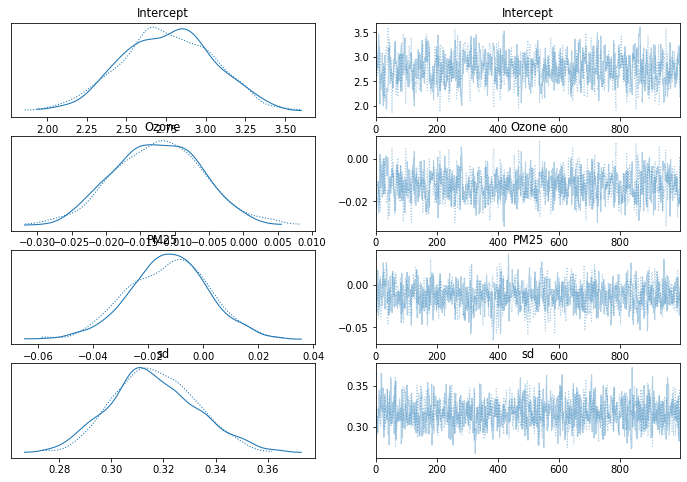

In [212]:
arviz.plot_trace(gaussian_trace_standard)

In [213]:
print(pm.summary(gaussian_trace_standard).round(4))

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  2.760  0.300   2.190    3.298      0.012    0.008     644.0   
Ozone     -0.012  0.006  -0.024   -0.000      0.000    0.000     787.0   
PM25      -0.013  0.015  -0.040    0.016      0.001    0.000     831.0   
sd         0.316  0.016   0.288    0.348      0.000    0.000    1167.0   

           ess_tail  r_hat  
Intercept     879.0    1.0  
Ozone         893.0    1.0  
PM25          888.0    1.0  
sd           1215.0    1.0  


We're curious about the performance of our Bayesian model. And we did the same trick to calculate rmse for the bayeisan model we just got.

In [214]:
bayesian_train_predict2 = np.exp(2.73 - 0.011 * train_not2011['Ozone'] + 0.002 * train_not2011['PM25'])
bayesian_test_predict2 = np.exp(2.73 - 0.011 * test_not2011['Ozone'] + 0.002 * test_not2011['PM25'])

train_rmse2 = RMSE(train_not2011['Prevalence'],bayesian_train_predict2)
test_rmse2 = RMSE(test_not2011['Prevalence'],bayesian_test_predict2)

print('Training set error for Bayesian Modeling:',train_rmse2)
print('Test set error for Bayesian Modeling:',test_rmse2)

Training set error for Bayesian Modeling: 2.972947306432409
Test set error for Bayesian Modeling: 3.1381044724849656


**Quick Summary:**
- Holding other variable constant, increasing one uint of ozone level is predicted to result in a decrease of 0.0012 unit of asthma prevalence on average.
- The RMSE we got for this model is not ideal.

### 2) Then, we add Gender to our Bayesian model with derived priors excluding data from 2011

In [215]:
model_2011_gender = smf.glm(formula='Log_Prevalence ~ PM25 + Ozone + Female', 
                            data=prevalence_2011_onehot, family=sm.families.Gaussian())
model_2011_gender_results = model_2011_gender.fit()
print(model_2011_gender_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         Log_Prevalence   No. Observations:                   98
Model:                            GLM   Df Residuals:                       94
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                        0.024312
Method:                          IRLS   Log-Likelihood:                 45.109
Date:                Sat, 11 Dec 2021   Deviance:                       2.2853
Time:                        13:05:18   Pearson chi2:                     2.29
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4688      0.285      8.668      0.0

We've never tried a frequentist GLM with only PM2.5 and ozone before. Thus, we did one here and compared it to our Bayesian model.

In [216]:
with pm.Model() as gaussian_model:
    priors = {
        "Ozone": pm.Normal.dist(mu=-0.0108, sigma=0.006),
        "PM25": pm.Normal.dist(mu=-0.0167, sigma=0.013),
        'Female':pm.Normal.dist(mu=0.5402, sigma=0.032)
    }
    pm.GLM.from_formula('Log_Prevalence ~ Ozone + PM25 + Female', data = train_not2011, 
                         family = pm.glm.families.Normal(), priors = priors)
    # draw posterior samples
    gaussian_trace_standard = pm.sample(1000, cores=1, target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, Female, PM25, Ozone, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 68 seconds.


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'Ozone'}>,
        <AxesSubplot:title={'center':'Ozone'}>],
       [<AxesSubplot:title={'center':'PM25'}>,
        <AxesSubplot:title={'center':'PM25'}>],
       [<AxesSubplot:title={'center':'Female'}>,
        <AxesSubplot:title={'center':'Female'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

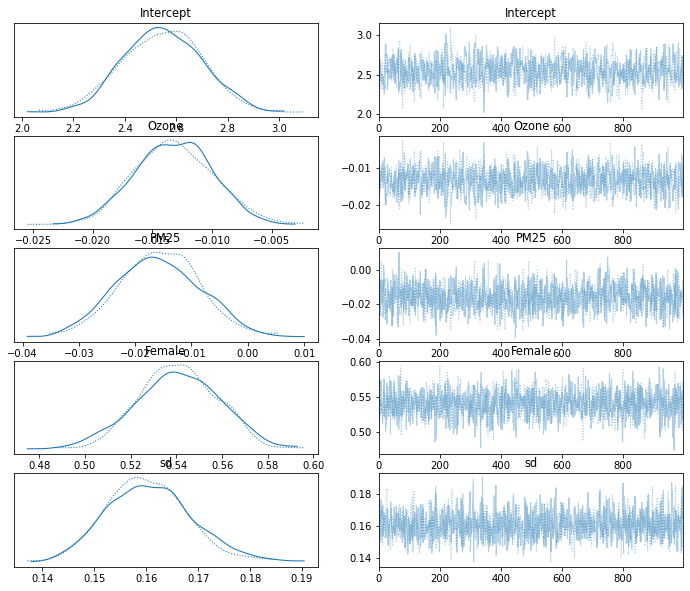

In [217]:
arviz.plot_trace(gaussian_trace_standard)

In [218]:
print(pm.summary(gaussian_trace_standard).round(4))

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  2.546  0.153   2.272    2.834      0.005    0.004     876.0   
Ozone     -0.013  0.003  -0.019   -0.007      0.000    0.000    1025.0   
PM25      -0.016  0.007  -0.030   -0.002      0.000    0.000    1270.0   
Female     0.541  0.018   0.506    0.574      0.000    0.000    1377.0   
sd         0.160  0.008   0.145    0.175      0.000    0.000    1617.0   

           ess_tail  r_hat  
Intercept     978.0    1.0  
Ozone        1000.0    1.0  
PM25         1277.0    1.0  
Female       1095.0    1.0  
sd           1140.0    1.0  


In [219]:
bayesian_train_predict2 = np.exp(2.552 - 0.013 * train_not2011['Ozone'] - 0.016 * train_not2011['PM25'] + 0.54 * train_not2011['Female'] )
bayesian_test_predict2 = np.exp(2.552 - 0.013 * test_not2011['Ozone'] - 0.016 * test_not2011['PM25'] + 0.54 * test_not2011['Female'] )

train_rmse2 = RMSE(train_not2011['Prevalence'],bayesian_train_predict2)
test_rmse2 = RMSE(test_not2011['Prevalence'],bayesian_test_predict2)

print('Training set error for Bayesian Modeling:',train_rmse2)
print('Test set error for Bayesian Modeling:',test_rmse2)

Training set error for Bayesian Modeling: 1.4266482206902373
Test set error for Bayesian Modeling: 1.310922828296766


**Quick Summary:** 
- Holding other variable constant, increasing one uint of ozone level is predicted to result in a decrease of 0.0013 unit of asthma prevalence on average.
- After we add gender to our Bayesian model, the RMSE we got significantly decreases. However, its performance is still not as good as the Frequentist model with Gamma family using Gender, State, Ozone, and PM2.5 as parameters.

### Results Summary

Here's a table summarizing the results of our models:

| Variables used | Method | Coefficient for Ozone | Train RMSE | Test RMSE |
|----------------------|--------|-----------------------|------------|-----------|
| Location & Race & PM2.5 & Ozone | Frequentist GLM | -0.0005 (p-val = 552) | 2.728 | 3.291 |
| Location & Race & PM2.5 & Ozone | Decision Tree | Not Applicable | 0 | 4.231 |
| Location & Race & PM2.5 & Ozone | Random Forest | Not Applicable | 1.223 | 3.268 |
| Location & Race & PM2.5 & Ozone | k-NN | Not Applicable | 3.334 | 3.494 |
| Location & Gender & PM2.5 & Ozone  | Frequentist GLM | 0.0006 (p-val = 0.324) | 0.719 | 0.993 |
| Location & Gender & PM2.5 & Ozone | Decision Tree | Not Applicable | 0 | 1.223 |
| Location & Gender & PM2.5 & Ozone | Random Forest | Not Applicable | 0.443 | 1.132 |
| Location & Gender & PM2.5 & Ozone | k-NN | Not Applicable | 1.422 | 1.525 |
| PM2.5 & Ozone | Bayesian GLM | -0.012 | 2.972 | 3.138 |
| Gender & PM2.5 & Ozone | Bayesian GLM  | -0.013 | 1.426 | 1.311 |

### Discussion

**1. Which model performed better, and why? How confident are you in applying this to future datasets?**

Frequentist GLMs with parameters gender, state, ozone, and PM2.5 perform best among all other models. 

- Models taking gender into account, overall speaking, perform than models taking race into account, meaning that gender plays a more important role in predicting asthma prevalence than race does.
- Frequentist GLM models perform better overall than Bayesian GLM models. Due to technical limits, we can't input the same features into the Bayesian models; thus, in our case, Freqeuntist GLM would be a better choice.
- GLM in general performs better than non-parametric methods.

However, we're **not confident** in applying our model to future datasets.

**2. Explain the results from both models. You may choose to not provide explanations, but you must justify this choice.**

I think we would cover this question in the results part.

**3. Elaborate on the limitations of your models.**

- We assume linearity when performing GLMs; however, the result shows that there might not be a strong linear relationship between prevalence of asthma and ozone level. 
- We can't include as many features as we do for frequentist models for Bayesian models.
- Non-parametric models perform good but they're hard to intepret.

**4. What additional data would be useful for improving your models?**

Like what we discussed in research question 1, to build a more accurate model and show the fluctuations of ozone more apprently, we need monthly asthma data to analyze the causal impact of ozone seasonally. 

If we could have more information about other possible features i.e. number of factories in one state, people's health-related data, etc., we could have more accurate models.


# End of Final Project!!!